In [1]:
pip freeze > model_requirements.txt    

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_train_df = pd.read_csv("data_train_csv")
data_smauto_train_df = pd.read_csv("data_smauto_train_csv")
data_smin_train_df = pd.read_csv("data_smin_train_csv")

data_test_df = pd.read_csv("data_test_csv")
data_val_df = pd.read_csv("data_val_csv")

In [4]:
print(f'Data_train: {data_train_df.shape}, Data smauto: {data_smauto_train_df.shape}, Data smin: {data_smin_train_df.shape}')

Data_train: (198047, 9), Data smauto: (301677, 9), Data smin: (296133, 9)


In [5]:
#own module which takes in df for train, test and val and returns in x and y format.  Can also sample.
from data_formatting import data_format

In [6]:
print(data_train_df['Winner_num'].value_counts())
print(data_smauto_train_df['Winner_num'].value_counts())
print(data_smin_train_df['Winner_num'].value_counts())

Winner_num
0    100559
2     95015
1      2473
Name: count, dtype: int64
Winner_num
0    100559
2    100559
1    100559
Name: count, dtype: int64
Winner_num
0    100559
1    100559
2     95015
Name: count, dtype: int64


Random Forest model

Train the baseline RF classifier

NOTE: Should I turn this into a function to call here and at the end?

In [7]:
def rf(train_data, test_data, val_data, sample, proportion):
    #own module which takes in df for train, test and val and returns in x and y format.  Can also sample.
    from data_formatting import data_format
    X_train, X_test, X_val, y_train, y_test, y_val = data_format(train_data, test_data, val_data, sample, proportion)

    model = RandomForestClassifier(random_state=7)
    model.fit(X_train, y_train)

    model_train_score = model.score(X_train, y_train)
    model_test_score = model.score(X_test, y_test)
    print(f"Training score: {model_train_score}, Testing score: {model_test_score}" )

    y_pred = model.predict(X_test)

    labels = ['Team 1', 'Tie', 'Team 2']
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

    cmd.plot()
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

    print(classification_report(y_test, y_pred, target_names=labels))

Training score: 0.9709412412205184, Testing score: 0.9325822474983803


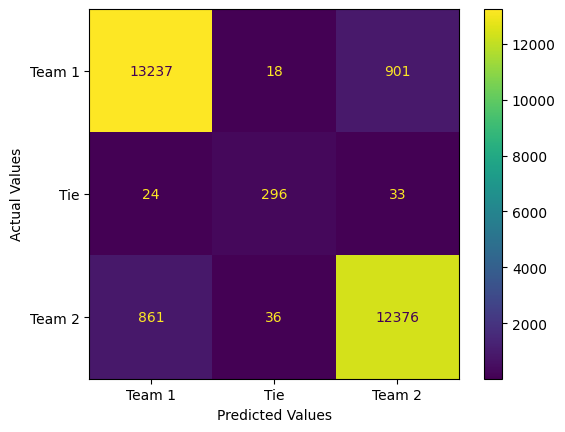

              precision    recall  f1-score   support

      Team 1       0.94      0.94      0.94     14156
         Tie       0.85      0.84      0.84       353
      Team 2       0.93      0.93      0.93     13273

    accuracy                           0.93     27782
   macro avg       0.90      0.90      0.90     27782
weighted avg       0.93      0.93      0.93     27782



In [8]:
rf(data_train_df, data_test_df, data_val_df, None, None)

Training score: 0.9809233053895391, Testing score: 0.9324382693830537


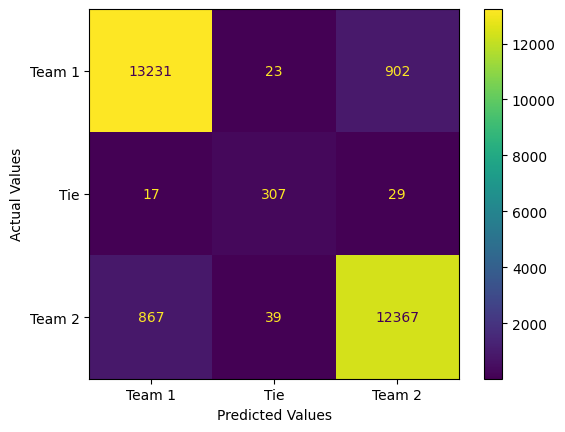

              precision    recall  f1-score   support

      Team 1       0.94      0.93      0.94     14156
         Tie       0.83      0.87      0.85       353
      Team 2       0.93      0.93      0.93     13273

    accuracy                           0.93     27782
   macro avg       0.90      0.91      0.91     27782
weighted avg       0.93      0.93      0.93     27782



In [9]:
rf(data_smauto_train_df, data_test_df, data_val_df, None, None)

Training score: 0.9805661645274252, Testing score: 0.9322223022100641


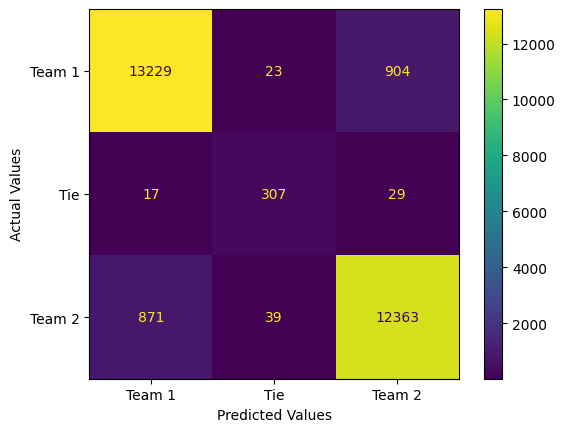

              precision    recall  f1-score   support

      Team 1       0.94      0.93      0.94     14156
         Tie       0.83      0.87      0.85       353
      Team 2       0.93      0.93      0.93     13273

    accuracy                           0.93     27782
   macro avg       0.90      0.91      0.91     27782
weighted avg       0.93      0.93      0.93     27782



In [10]:
rf(data_smin_train_df, data_test_df, data_val_df, None, None)

Using min because recall is the more importantmetric in this case. Recall is the number of true positives/ true positives + False negatives.  I.e. out of the number of times it was actually positive, how many times did we predict it to be so.  Not as much of a concern for false negatives in category 1 because it has less impact than incorrectly giving the win to another team.

<ins>**Tune the RF**</ins>

Because I'm using the full data, chosen to train on each parameter in turn and plot results.  In other models, chose to run the combinations but I used a sample of the data instead.

In [11]:
X_train, X_test, X_val, y_train, y_test, y_val = data_format(data_smin_train_df, data_test_df, data_val_df, None, None)

In [12]:
#Tuning on Estimators as well as the below

param_grid = {
    'max_depth': [10, 20, 30, 40 ,50, 60, 70, 80, 90, 100],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [10, 50, 100, 200],
    'max_leaf_nodes': [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000],
    'min_samples_leaf': [1, 100, 200, 300, 400, 500],
    'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    }

1 n_estimators, Train Accuracy: 0.972633917867985, Validation Accuracy: 0.9245721073376167
1 n_estimators, Train Loss: 0.6089798170161196, Validation Loss: 2.405789985159796
51 n_estimators, Train Accuracy: 0.9805425264999172, Validation Accuracy: 0.9333729280276443
51 n_estimators, Train Loss: 0.03619508267016046, Validation Loss: 0.27463921576026223
101 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9338048701474002
101 n_estimators, Train Loss: 0.036007656932007144, Validation Loss: 0.24104140809972244
151 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9343987905620647
151 n_estimators, Train Loss: 0.03603056519405913, Validation Loss: 0.22961784501074295
201 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9345787664452964
201 n_estimators, Train Loss: 0.035987033931168, Validation Loss: 0.22400904867144006
251 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9349207206234365
251 n_e

C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


401 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9350467037416986
401 n_estimators, Train Loss: 0.03591689531355408, Validation Loss: 0.21485781801085882


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


451 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9351006965066682
451 n_estimators, Train Loss: 0.035911783192843376, Validation Loss: 0.21378055966290407


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


501 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9352266796249302
501 n_estimators, Train Loss: 0.03591005208888485, Validation Loss: 0.21369349471625926


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


551 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9352086820366071
551 n_estimators, Train Loss: 0.03590788539841345, Validation Loss: 0.2130935769330614


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


601 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9351906844482839
601 n_estimators, Train Loss: 0.03590501470607058, Validation Loss: 0.2120318575722716


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


651 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9352806723898998
651 n_estimators, Train Loss: 0.035905018572899565, Validation Loss: 0.21198986125996172


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


701 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9352806723898998
701 n_estimators, Train Loss: 0.035896632734733314, Validation Loss: 0.21201821550159894


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


751 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9352446772132534
751 n_estimators, Train Loss: 0.03590444550131786, Validation Loss: 0.21142756624781375


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


801 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9351186940949913
801 n_estimators, Train Loss: 0.03590280096370614, Validation Loss: 0.20985135358278603


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


851 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9351726868599608
851 n_estimators, Train Loss: 0.035904779856099855, Validation Loss: 0.208858427789888


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


901 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9351366916833145
901 n_estimators, Train Loss: 0.0359079525785823, Validation Loss: 0.20884399029330972


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


951 n_estimators, Train Accuracy: 0.9805661645274252, Validation Accuracy: 0.9351726868599608
951 n_estimators, Train Loss: 0.035904792618455826, Validation Loss: 0.20830944844018676
Best accuracy is: 0.9352806723898998 and estimators is 651
Best loss is: 0.20830944844018676 and estimators is 951


C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


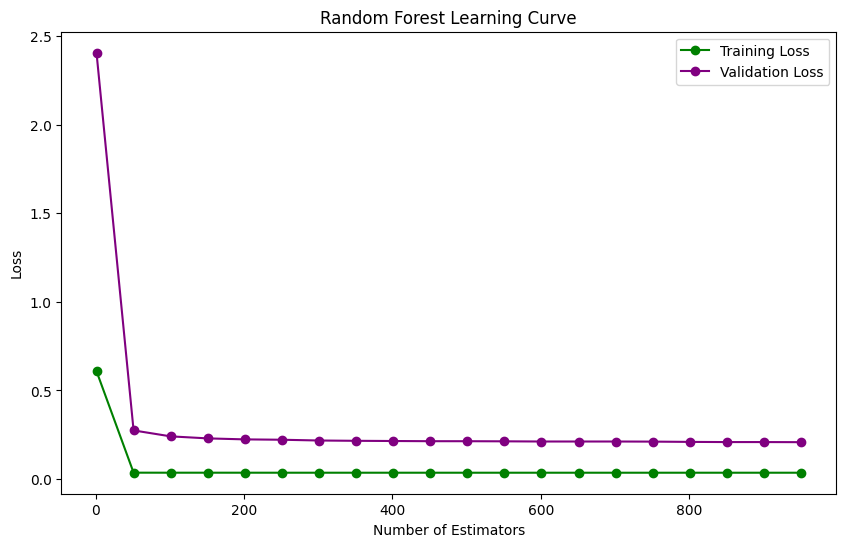

In [28]:
best_accuracy = 0
best_loss=100
estimators = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for e in range(1,1001, 50):
    estimators.append(e)

    model = RandomForestClassifier(n_estimators=e, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)

    #Training accuracy and loss
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    #Need the probability rather than predicted class
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    train_loss_list.append(train_loss)

    #Validation accuracy and loss
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_loss_list.append(val_loss)


    print(f"{e} n_estimators, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"{e} n_estimators, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_acc_estimators = e

    if val_loss< best_loss:
        best_loss = val_loss
        best_loss_estimators = e
    
estimators_acc_df = pd.DataFrame({'Estimators': estimators,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
estimators_loss_df = pd.DataFrame({'Estimators': estimators,'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})



print(f"Best accuracy is: {best_accuracy} and estimators is {best_acc_estimators}")
print(f"Best loss is: {best_loss} and estimators is {best_loss_estimators}")

plt.figure(figsize=(10, 6))

#Accuracy curves
#plt.plot()
#plt.title('Random Forest Learning Curve')
#plt.xlabel('Number of Estimators')
#plt.ylabel('Accuracy')
#plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
#plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
#plt.legend()

#Loss curves
plt.plot()
plt.title('Random Forest Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Loss')
plt.plot(estimators_loss_df['Estimators'], estimators_loss_df['Train Loss'], label='Training Loss', color='green', marker='o')
plt.plot(estimators_loss_df['Estimators'], estimators_loss_df['Validation Loss'], label='Validation Loss', color='purple', marker='o')
plt.legend()

#plt.tight_layout()
plt.show()

50 n_estimators, Train Accuracy: 0.9805391496388447, Validation Accuracy: 0.9333549304393212
50 n_estimators, Train Loss: 0.0362067089220526, Validation Loss: 0.27709617660081026
55 n_estimators, Train Accuracy: 0.980552657083135, Validation Accuracy: 0.9333009376743516
55 n_estimators, Train Loss: 0.03614810779811246, Validation Loss: 0.2699414470065815
60 n_estimators, Train Accuracy: 0.9805492802220623, Validation Accuracy: 0.9334809135575833
60 n_estimators, Train Loss: 0.03613209634046739, Validation Loss: 0.26343454170807773
65 n_estimators, Train Accuracy: 0.9805560339442075, Validation Accuracy: 0.9333909256159675
65 n_estimators, Train Loss: 0.03608345230667408, Validation Loss: 0.25985281850008196
70 n_estimators, Train Accuracy: 0.980552657083135, Validation Accuracy: 0.9336608894408149
70 n_estimators, Train Loss: 0.03608043502094073, Validation Loss: 0.2570936094223977
75 n_estimators, Train Accuracy: 0.9805594108052801, Validation Accuracy: 0.9337148822057845
75 n_estimat

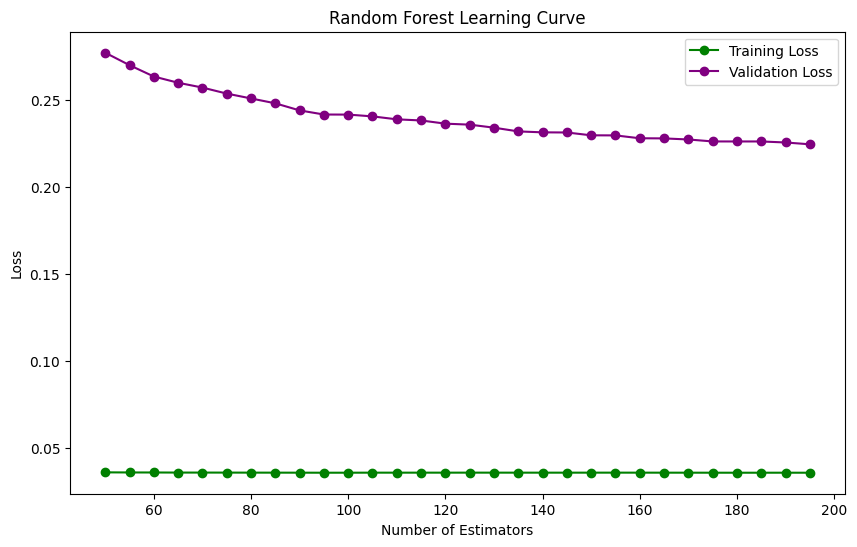

In [29]:
best_accuracy = 0
best_loss=100
estimators = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for e in range(50,200, 5):
    estimators.append(e)

    model = RandomForestClassifier(n_estimators=e, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)

    #Training accuracy and loss
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    #Need the probability rather than predicted class
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    train_loss_list.append(train_loss)

    #Validation accuracy and loss
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_loss_list.append(val_loss)


    print(f"{e} n_estimators, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"{e} n_estimators, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_acc_estimators = e

    if val_loss< best_loss:
        best_loss = val_loss
        best_loss_estimators = e
    
estimators_acc_df = pd.DataFrame({'Estimators': estimators,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
estimators_loss_df = pd.DataFrame({'Estimators': estimators,'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})



print(f"Best accuracy is: {best_accuracy} and estimators is {best_acc_estimators}")
print(f"Best loss is: {best_loss} and estimators is {best_loss_estimators}")

plt.figure(figsize=(10, 6))

#Accuracy curves
#plt.plot()
#plt.title('Random Forest Learning Curve')
#plt.xlabel('Number of Estimators')
#plt.ylabel('Accuracy')
#plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
#plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
#plt.legend()

#Loss curves
plt.plot()
plt.title('Random Forest Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Loss')
plt.plot(estimators_loss_df['Estimators'], estimators_loss_df['Train Loss'], label='Training Loss', color='green', marker='o')
plt.plot(estimators_loss_df['Estimators'], estimators_loss_df['Validation Loss'], label='Validation Loss', color='purple', marker='o')
plt.legend()

#plt.tight_layout()
plt.show()

Max Depth

In [34]:
best_accuracy = 0
best_loss=100
depth_list = []
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for md in param_grid['max_depth']:
    depth_list.append(md)

    model = RandomForestClassifier(n_estimators=185, max_depth=md, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)

    #Training accuracy and loss
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    #Need the probability rather than predicted class
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    train_loss_list.append(train_loss)

    #Validation accuracy and loss
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    val_loss = log_loss(y_val, model.predict_proba(X_val))
    val_loss_list.append(val_loss)


    print(f"{md} Max Depth, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
    print(f"{md} Max Depth, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_acc_md = md

    if val_loss< best_loss:
        best_loss = val_loss
        best_loss_md = md
    
depth_acc_df = pd.DataFrame({'Max Depth': depth_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})
depth_loss_df = pd.DataFrame({'Max Depth': depth_list,'Train Loss': train_loss_list, 'Validation Loss': val_loss_list})



print(f"Best accuracy is: {best_accuracy} and estimators is {best_acc_loss}")
print(f"Best loss is: {best_loss} and estimators is {best_loss_loss}")

plt.figure(figsize=(10, 6))

#Accuracy curves
#plt.plot()
#plt.title('Random Forest Learning Curve')
#plt.xlabel('Number of Estimators')
#plt.ylabel('Accuracy')
#plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
#plt.plot(estimators_acc_df['Estimators'], estimators_acc_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
#plt.legend()

#Loss curves
plt.plot()
plt.title('Random Forest Learning Curve')
plt.xlabel('Number of Estimators')
plt.ylabel('Loss')
plt.plot(depth_loss_df['Max Depth'], depth_loss_df['Train Loss'], label='Training Loss', color='green', marker='o')
plt.plot(depth_loss_df['Max Depth'], depth_loss_df['Validation Loss'], label='Validation Loss', color='purple', marker='o')
plt.legend()

#plt.tight_layout()
plt.show()

10 Max Depth, Train Accuracy: 0.8677351055100242, Validation Accuracy: 0.8013426200889081
10 Max Depth, Train Loss: 0.38162973053414306, Validation Loss: 0.5026454408281492
20 Max Depth, Train Accuracy: 0.9785468016060351, Validation Accuracy: 0.9441354858448968
20 Max Depth, Train Loss: 0.06650301398443144, Validation Loss: 0.13357168470729341


10 max depth, Train Accuracy: 0.8514239292322968, Validation Accuracy: 0.7799056341937275
11 max depth, Train Accuracy: 0.8734937040213026, Validation Accuracy: 0.8111388657600148
12 max depth, Train Accuracy: 0.8922722806822639, Validation Accuracy: 0.8366361365528726
13 max depth, Train Accuracy: 0.9120958474661593, Validation Accuracy: 0.8650939032287909
14 max depth, Train Accuracy: 0.9306626487201475, Validation Accuracy: 0.8899620686464983
15 max depth, Train Accuracy: 0.9463652743880212, Validation Accuracy: 0.9112036266074568
16 max depth, Train Accuracy: 0.9574886908460948, Validation Accuracy: 0.9259135905264132
17 max depth, Train Accuracy: 0.9656125343267105, Validation Accuracy: 0.9346655564807105
18 max depth, Train Accuracy: 0.9712957530351581, Validation Accuracy: 0.9389212693126099
19 max depth, Train Accuracy: 0.9747709527463104, Validation Accuracy: 0.9405125358497548
20 max depth, Train Accuracy: 0.9774441832933506, Validation Accuracy: 0.9396243870848368
21 max dep

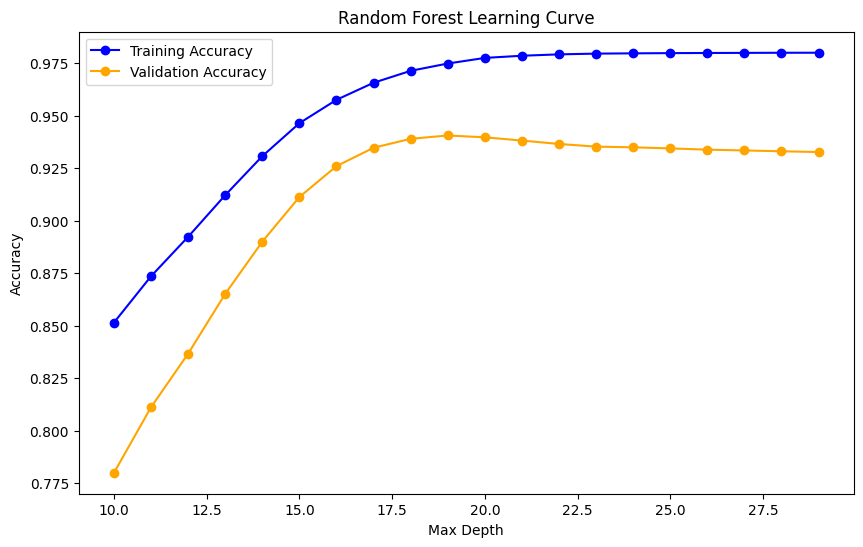

In [ ]:
best_accuracy = 0
depth_list = []
train_acc_list = []
val_acc_list = []
for md in range(10, 30):
    depth_list.append(md)

    model = RandomForestClassifier(n_estimators=719, max_depth=md, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{md} max depth, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_depth= md

print(f"Best accuracy is: {best_accuracy} and depth is {best_depth}")
depth_df = pd.DataFrame({'Max Depth': depth_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.plot(depth_df['Max Depth'], depth_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(depth_df['Max Depth'], depth_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

1 max features, Train Accuracy: 0.969362000548533, Validation Accuracy: 0.9281339624387085
2 max features, Train Accuracy: 0.9747709527463104, Validation Accuracy: 0.9405125358497548
3 max features, Train Accuracy: 0.975993000996386, Validation Accuracy: 0.9417522435007863
4 max features, Train Accuracy: 0.976222135043275, Validation Accuracy: 0.9421223054861689
5 max features, Train Accuracy: 0.975871490516975, Validation Accuracy: 0.9420667961883615
6 max features, Train Accuracy: 0.9751285407285768, Validation Accuracy: 0.9426033860671662
7 max features, Train Accuracy: 0.9728094264358199, Validation Accuracy: 0.9416782311037099
8 max features, Train Accuracy: 0.9619949937682483, Validation Accuracy: 0.9291886390970487
Best accuracy is: 0.9426033860671662 and max features is 6


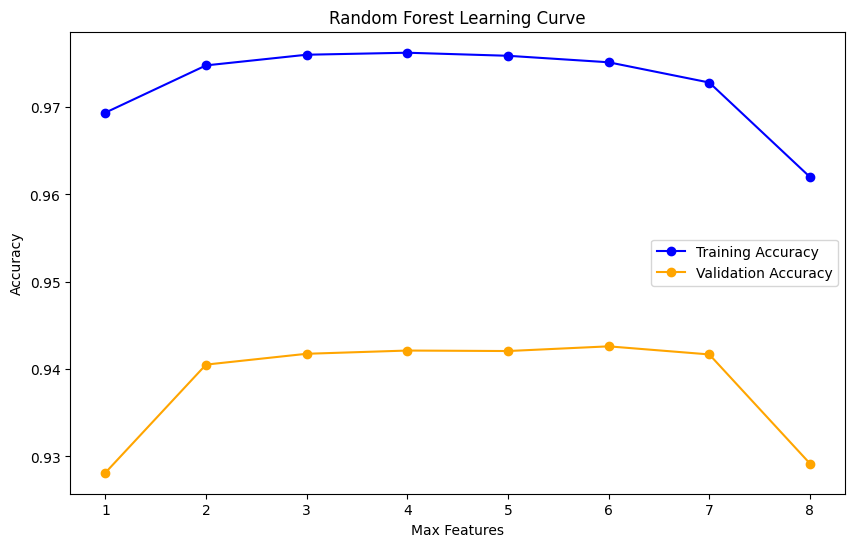

In [ ]:
best_accuracy = 0
maxfeatures_list = []
train_acc_list = []
val_acc_list = []
for mf in range(1,9):
    maxfeatures_list.append(mf)

    model = RandomForestClassifier(n_estimators=719, max_depth=19, max_features=mf,n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{mf} max features, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_maxfeatures= mf

print(f"Best accuracy is: {best_accuracy} and max features is {best_maxfeatures}")
mf_df = pd.DataFrame({'Max Features': maxfeatures_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.plot(mf_df['Max Features'], mf_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(mf_df['Max Features'], mf_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

10 min sample, Train Accuracy: 0.9745036296916064, Validation Accuracy: 0.9455823850494958
50 min sample, Train Accuracy: 0.9632448158421891, Validation Accuracy: 0.9383106670367286
100 min sample, Train Accuracy: 0.9481150252915383, Validation Accuracy: 0.9184383384216857
200 min sample, Train Accuracy: 0.9232157921962498, Validation Accuracy: 0.8841335923767231
Best accuracy is: 0.9455823850494958 and min samples split is 10


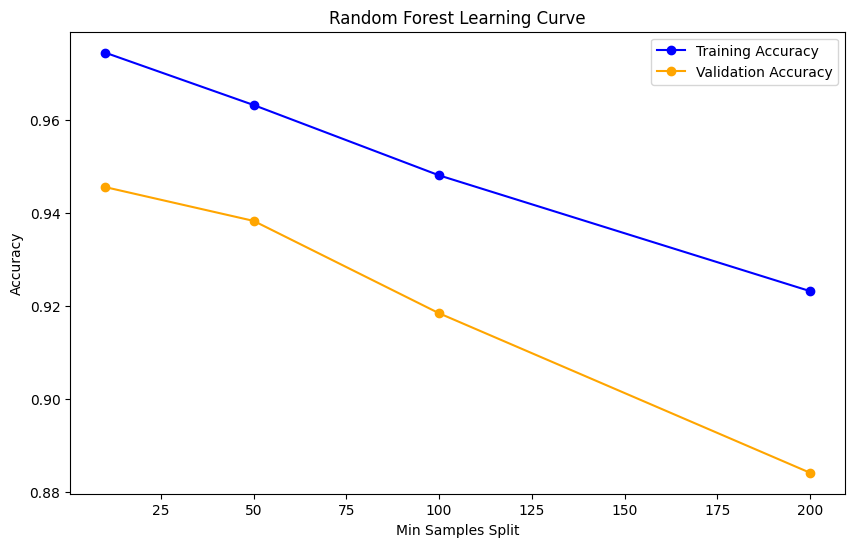

In [ ]:
best_accuracy = 0
mss_list = []
train_acc_list = []
val_acc_list = []
for mss in param_grid['min_samples_split']:
    mss_list.append(mss)

    model = RandomForestClassifier(n_estimators=719, max_depth=19, max_features=4, min_samples_split=mss,n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{mss} min sample, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_mss= mss

print(f"Best accuracy is: {best_accuracy} and min samples split is {best_mss}")
mss_df = pd.DataFrame({'Min Samples Split': mss_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.plot(mss_df['Min Samples Split'], mss_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(mss_df['Min Samples Split'], mss_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

In [ ]:
best_accuracy = 0
mss_list = []
train_acc_list = []
val_acc_list = []
for mss in range(2,51):
    mss_list.append(mss)

    model = RandomForestClassifier(n_estimators=719, max_depth=19, max_features=4, min_samples_split=mss,n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{mss} min sample, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_mss= mss

print(f"Best accuracy is: {best_accuracy} and min samples split is {best_mss}")    
mss_df = pd.DataFrame({'Min Samples Split': mss_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.plot(mss_df['Min Samples Split'], mss_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(mss_df['Min Samples Split'], mss_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

2 min sample, Train Accuracy: 0.976222135043275, Validation Accuracy: 0.9421223054861689
3 min sample, Train Accuracy: 0.9761735308515107, Validation Accuracy: 0.9422703302803219
4 min sample, Train Accuracy: 0.9760485486441166, Validation Accuracy: 0.9430659635488945
5 min sample, Train Accuracy: 0.9758541318770592, Validation Accuracy: 0.943436025534277
6 min sample, Train Accuracy: 0.9755763936384056, Validation Accuracy: 0.9437320751225831
7 min sample, Train Accuracy: 0.9751840883763075, Validation Accuracy: 0.9445832176889629
8 min sample, Train Accuracy: 0.974906350137654, Validation Accuracy: 0.9446942362845777
9 min sample, Train Accuracy: 0.974618196715051, Validation Accuracy: 0.9452308261633824
10 min sample, Train Accuracy: 0.9745036296916064, Validation Accuracy: 0.9455823850494958
11 min sample, Train Accuracy: 0.9743647605722796, Validation Accuracy: 0.9458044222407254
12 min sample, Train Accuracy: 0.97400370086203, Validation Accuracy: 0.9459709501341474
13 min sample

KeyboardInterrupt: 

500 max leaf nodes, Train Accuracy: 0.8915223874378995, Validation Accuracy: 0.8396336386344713
1000 max leaf nodes, Train Accuracy: 0.9286073857541114, Validation Accuracy: 0.8916828568785271
1500 max leaf nodes, Train Accuracy: 0.9468652032175975, Validation Accuracy: 0.9165695253955037
2000 max leaf nodes, Train Accuracy: 0.9572109526074413, Validation Accuracy: 0.9313349986122675
2500 max leaf nodes, Train Accuracy: 0.9633316090417684, Validation Accuracy: 0.9396058839855675
3000 max leaf nodes, Train Accuracy: 0.967636551740898, Validation Accuracy: 0.9435655472291609
3500 max leaf nodes, Train Accuracy: 0.9704139341274333, Validation Accuracy: 0.9455823850494958
4000 max leaf nodes, Train Accuracy: 0.9718165122326335, Validation Accuracy: 0.9464520307151448
4500 max leaf nodes, Train Accuracy: 0.9721845153988494, Validation Accuracy: 0.946914608196873
5000 max leaf nodes, Train Accuracy: 0.9721879871268326, Validation Accuracy: 0.946914608196873
5500 max leaf nodes, Train Accurac

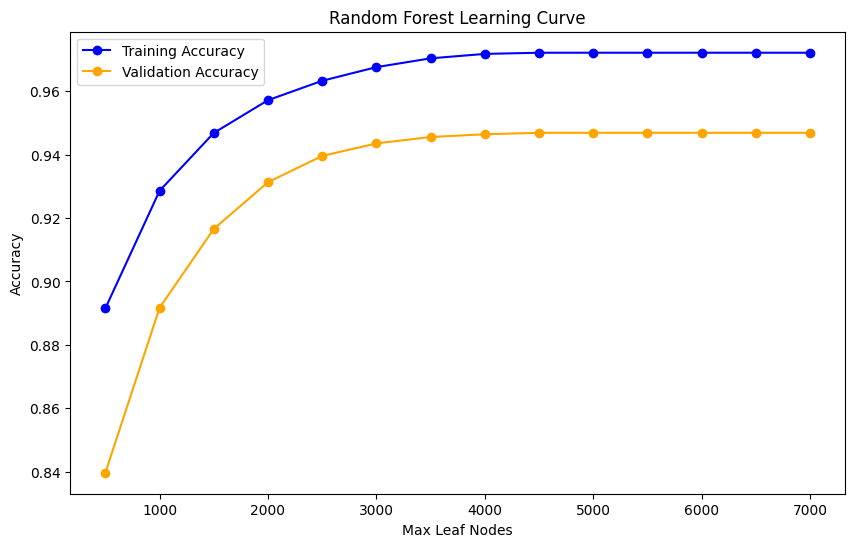

In [ ]:
best_accuracy = 0
mln_list = []
train_acc_list = []
val_acc_list = []
for mln in param_grid['max_leaf_nodes']:
    mln_list.append(mln)

    model = RandomForestClassifier(n_estimators=719, max_depth=19, max_features=4, min_samples_split=20,max_leaf_nodes=mln, n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{mln} max leaf nodes, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_mln= mln
    
mln_df = pd.DataFrame({'Max Leaf Nodes': mln_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Accuracy')
plt.plot(mln_df['Max Leaf Nodes'], mln_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(mln_df['Max Leaf Nodes'], mln_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

1 min samples leaf, Train Accuracy: 0.9718165122326335, Validation Accuracy: 0.9464520307151448
100 min samples leaf, Train Accuracy: 0.8874743526095243, Validation Accuracy: 0.8349893607179203
200 min samples leaf, Train Accuracy: 0.8545797299689974, Validation Accuracy: 0.7883060412619114
300 min samples leaf, Train Accuracy: 0.8371933162292868, Validation Accuracy: 0.763012304561014
400 min samples leaf, Train Accuracy: 0.8266566218003687, Validation Accuracy: 0.7480062910537515
500 min samples leaf, Train Accuracy: 0.8183973809284095, Validation Accuracy: 0.7373114996761958


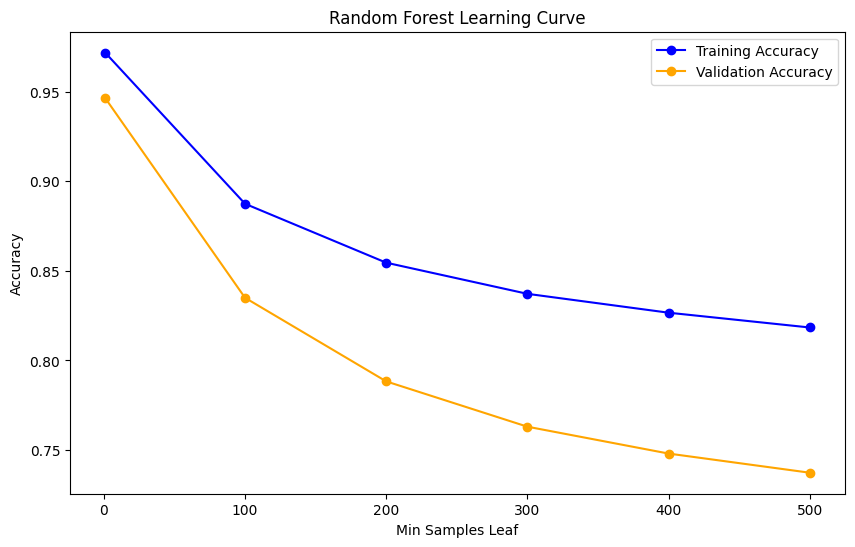

In [ ]:
best_accuracy = 0
msl_list = []
train_acc_list = []
val_acc_list = []

for msl in param_grid['min_samples_leaf']:
    msl_list.append(msl)

    model = RandomForestClassifier(n_estimators=719, max_depth=19, max_features=4, min_samples_split=20,max_leaf_nodes=4000, min_samples_leaf=msl,n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{msl} min samples leaf, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_msl= msl
    
msl_df = pd.DataFrame({'Min Samples Leaf': msl_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.plot(msl_df['Min Samples Leaf'], msl_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(msl_df['Min Samples Leaf'], msl_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

1 min samples leaf, Train Accuracy: 0.9718165122326335, Validation Accuracy: 0.9464520307151448
11 min samples leaf, Train Accuracy: 0.9659701223089768, Validation Accuracy: 0.9407900823387918
21 min samples leaf, Train Accuracy: 0.9542391534538486, Validation Accuracy: 0.9258210750300675
31 min samples leaf, Train Accuracy: 0.9416645546988103, Validation Accuracy: 0.9094643352761588
41 min samples leaf, Train Accuracy: 0.9310445387982961, Validation Accuracy: 0.8950874271440467
51 min samples leaf, Train Accuracy: 0.9219104224745782, Validation Accuracy: 0.8820982514571191
61 min samples leaf, Train Accuracy: 0.9131269506771605, Validation Accuracy: 0.8705893237117217
71 min samples leaf, Train Accuracy: 0.9053780538187272, Validation Accuracy: 0.8592469238597465
81 min samples leaf, Train Accuracy: 0.8985595800597832, Validation Accuracy: 0.8499953742251827
91 min samples leaf, Train Accuracy: 0.8930985519422582, Validation Accuracy: 0.8426126376168008


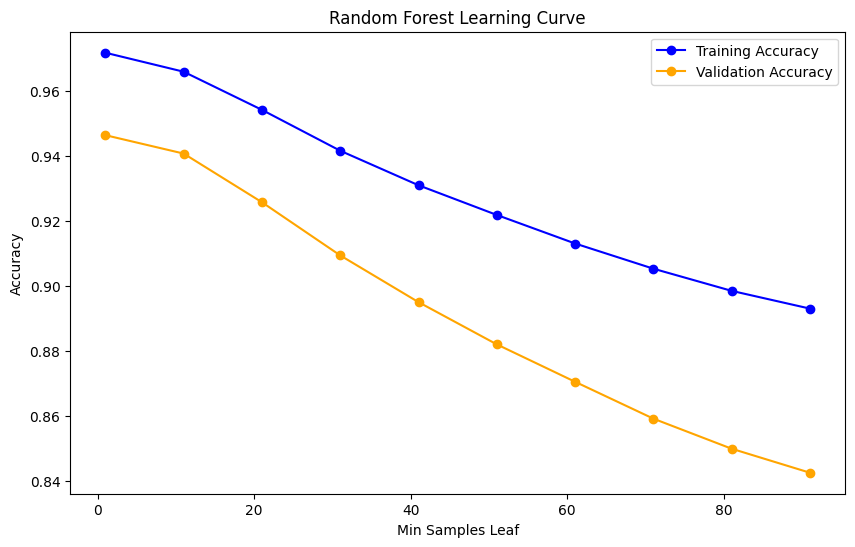

In [ ]:
best_accuracy = 0
msl_list = []
train_acc_list = []
val_acc_list = []

for msl in range(1,100, 10):
    msl_list.append(msl)

    model = RandomForestClassifier(n_estimators=719, max_depth=19, max_features=4, min_samples_split=20,max_leaf_nodes=4000, min_samples_leaf=msl,n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{msl} min samples leaf, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_msl= msl
    
msl_df = pd.DataFrame({'Min Samples Leaf': msl_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.plot(msl_df['Min Samples Leaf'], msl_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(msl_df['Min Samples Leaf'], msl_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

1 min samples leaf, Train Accuracy: 0.9718165122326335, Validation Accuracy: 0.9464520307151448
2 min samples leaf, Train Accuracy: 0.9716220954655761, Validation Accuracy: 0.9463965214173374
3 min samples leaf, Train Accuracy: 0.9712749226672591, Validation Accuracy: 0.9463595152187991
4 min samples leaf, Train Accuracy: 0.9708235980294472, Validation Accuracy: 0.9463225090202609
5 min samples leaf, Train Accuracy: 0.9703583864797025, Validation Accuracy: 0.9456934036451106
6 min samples leaf, Train Accuracy: 0.9698202686423113, Validation Accuracy: 0.9450828013692294
7 min samples leaf, Train Accuracy: 0.9692300748851725, Validation Accuracy: 0.9442871681006568
8 min samples leaf, Train Accuracy: 0.9685530879284546, Validation Accuracy: 0.9435655472291609
9 min samples leaf, Train Accuracy: 0.967924705163501, Validation Accuracy: 0.9426403922657045
10 min samples leaf, Train Accuracy: 0.9670949621755236, Validation Accuracy: 0.9419557775927467
11 min samples leaf, Train Accuracy: 0.9

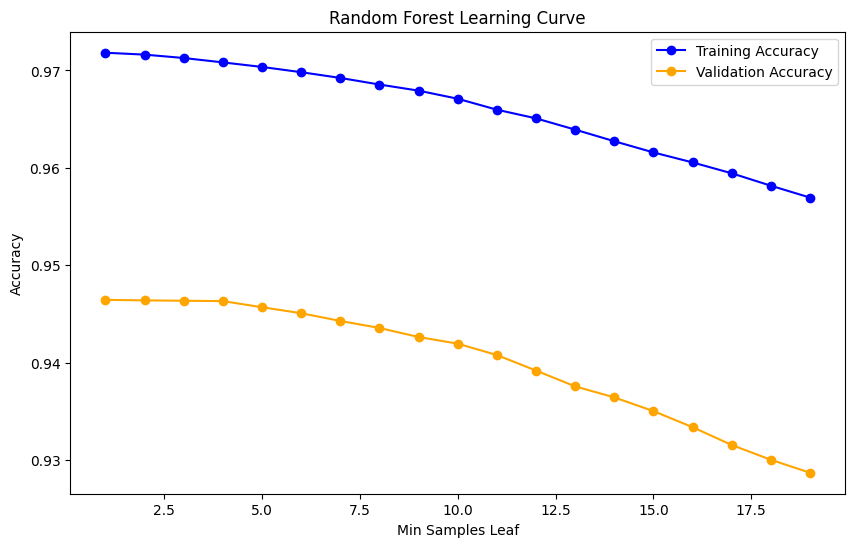

In [ ]:
best_accuracy = 0
msl_list = []
train_acc_list = []
val_acc_list = []

for msl in range(1,20):
    msl_list.append(msl)

    model = RandomForestClassifier(n_estimators=719, max_depth=19, max_features=4, min_samples_split=20,max_leaf_nodes=4000, min_samples_leaf=msl,n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{msl} min samples leaf, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_msl= msl
    
msl_df = pd.DataFrame({'Min Samples Leaf': msl_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.plot(msl_df['Min Samples Leaf'], msl_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(msl_df['Min Samples Leaf'], msl_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

0.1 max samples, Train Accuracy: 0.9206918459524859, Validation Accuracy: 0.8805995004163197
0.2 max samples, Train Accuracy: 0.9466742581785232, Validation Accuracy: 0.9158108983254695
0.3 max samples, Train Accuracy: 0.9574991060300443, Validation Accuracy: 0.9295772041817004
0.4 max samples, Train Accuracy: 0.9621234477036256, Validation Accuracy: 0.9358127486353964
0.5 max samples, Train Accuracy: 0.9652063421526796, Validation Accuracy: 0.939531871588491
0.6 max samples, Train Accuracy: 0.9668623564006513, Validation Accuracy: 0.9425848829678971
0.7 max samples, Train Accuracy: 0.9681573109383733, Validation Accuracy: 0.943880099916736
0.8 max samples, Train Accuracy: 0.9691085644057617, Validation Accuracy: 0.9447127393838468
0.9 max samples, Train Accuracy: 0.9697890230904628, Validation Accuracy: 0.9452493292626515


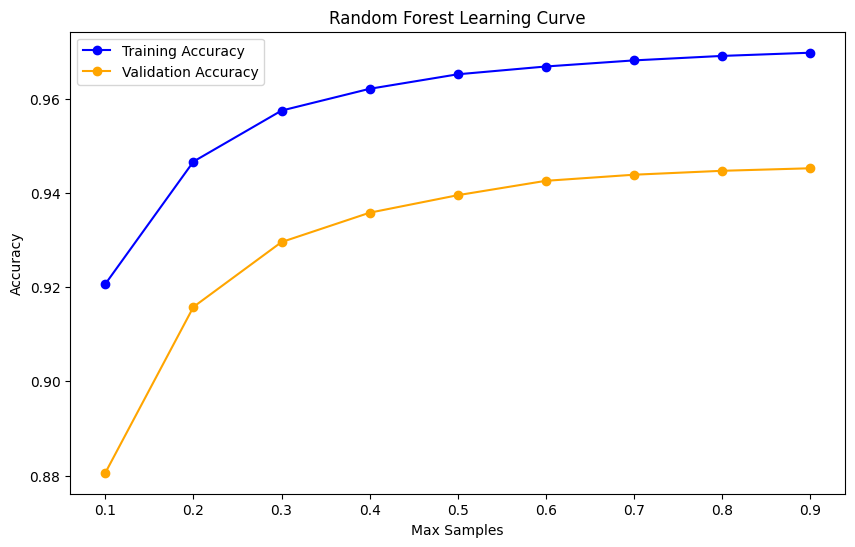

In [ ]:
best_accuracy = 0
maxs_list = []
train_acc_list = []
val_acc_list = []

for maxs in param_grid['max_samples']:
    maxs_list.append(maxs)

    model = RandomForestClassifier(n_estimators=719, max_depth=19, max_features=4, min_samples_split=20,max_leaf_nodes=4000, min_samples_leaf=5, max_samples=maxs,n_jobs=-1, random_state=7)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_acc_list.append(train_accuracy)

    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_acc_list.append(val_accuracy)

    print(f"{maxs} max samples, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")

    if val_accuracy> best_accuracy:
        best_accuracy = val_accuracy
        best_maxs = maxs
    
maxs_df = pd.DataFrame({'Max Samples': maxs_list,'Train Accuracy': train_acc_list, 'Validation Accuracy': val_acc_list})

plt.figure(figsize=(10, 6))
plt.title('Random Forest Learning Curve')
plt.xlabel('Max Samples')
plt.ylabel('Accuracy')
plt.plot(maxs_df['Max Samples'], maxs_df['Train Accuracy'], label='Training Accuracy', color='blue', marker='o')
plt.plot(maxs_df['Max Samples'], maxs_df['Validation Accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.legend()
plt.show()

In [ ]:

   
model = RandomForestClassifier(n_estimators=719, max_depth=19, max_features=4, min_samples_split=20,max_leaf_nodes=4000, min_samples_leaf=5, max_samples=0.9,n_jobs=-1, random_state=7)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}')

Training Accuracy: 0.9697890230904628, Validation Accuracy: 0.9452493292626515, Test Accuracy: 0.939419732070165


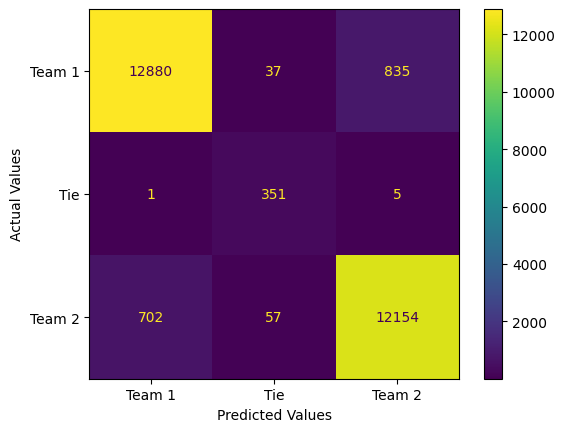

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     13752
           1       0.79      0.98      0.88       357
           2       0.94      0.94      0.94     12913

    accuracy                           0.94     27022
   macro avg       0.89      0.95      0.92     27022
weighted avg       0.94      0.94      0.94     27022



In [ ]:
labels = ['Team 1', 'Tie', 'Team 2']
cm = confusion_matrix(y_test, y_test_pred, labels=model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)

cmd.plot()
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print(classification_report(y_test, y_test_pred, target_name=labels))

In [ ]:
y_test_pred_list  = []
for y in y_test_pred:
    if y==0:
        y_test_pred_list.append("Y")
    elif y == 2:
        y_test_pred_list.append("N")
    elif y==1:
        y_test_pred_list.append("T")

In [ ]:
y_test_pred_df = pd.DataFrame(y_test_pred_list, columns=["Winner Bat First"])

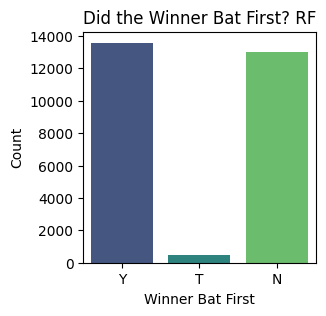

In [ ]:
plt.figure(figsize=(3, 3))
sns.countplot(x='Winner Bat First', data=y_test_pred_df, palette='viridis')

# Adding labels and title
plt.ylabel('Count')
plt.title('Did the Winner Bat First? RF')
plt.show()

In [ ]:
y_test_pred_df.value_counts(normalize=True)

Winner Bat First
Y                   0.502590
N                   0.480534
T                   0.016875
Name: proportion, dtype: float64

Mine shows less bias towards the second batting team

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Improved recall significantly, so it's now overpredicting that things are a tie, but that's preferable to incorrectly predicting one of the other two classes.  Also reduced the overfitting.

In [ ]:
#REMEMBER TO CHANGE TERMINAL NODES TO LEAF NODES IN THE PARAM GRIDS

https://github.com/ngoix/scikit-learn/commit/2661da0d3578eda406dcf1867443d9f744165c5f

Use the tuned hyperparameters for a new RF

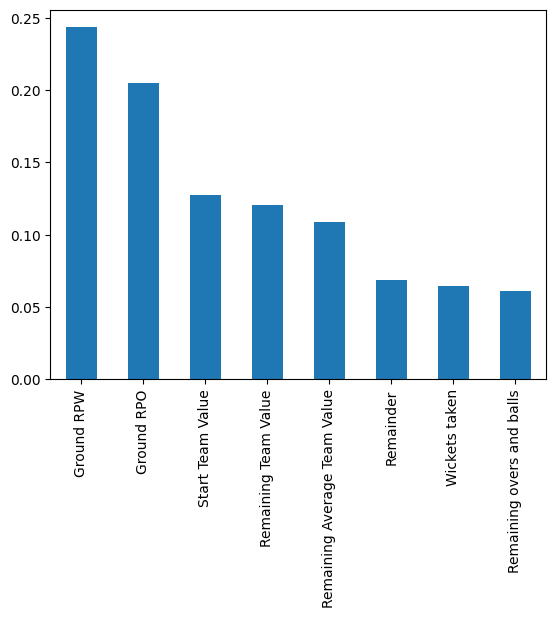

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

Challenge with feature selection is that the question here is whether the run rate of the ground, team value and remainder improve the performance rate of wickets taken and remaining overs and balls.

In [ ]:
data_train_df = pd.read_csv("data_train_csv")
data_smauto_train_df = pd.read_csv("data_smauto_train_csv")
data_smin_train_df = pd.read_csv("data_smin_train_csv")

data_test_df = pd.read_csv("data_test_csv")
data_val_df = pd.read_csv("data_val_csv")

In [ ]:
data_train_df = data_train_df.drop(['Remaining overs and balls', 'Remainder'], axis=1, inplace=False)
data_smauto_train_df = data_smauto_train_df.drop(['Remaining overs and balls', 'Remainder'], axis=1, inplace=False)
data_smin_train_df = data_smin_train_df.drop(['Remaining overs and balls', 'Remainder'], axis=1, inplace=False)

data_test_df = data_test_df.drop(['Remaining overs and balls', 'Remainder'], axis=1, inplace=False)
data_val_df = data_val_df.drop(['Remaining overs and balls', 'Remainder'], axis=1, inplace=False)

Training score: 0.921697692044145, Testing score: 0.9188439049663237


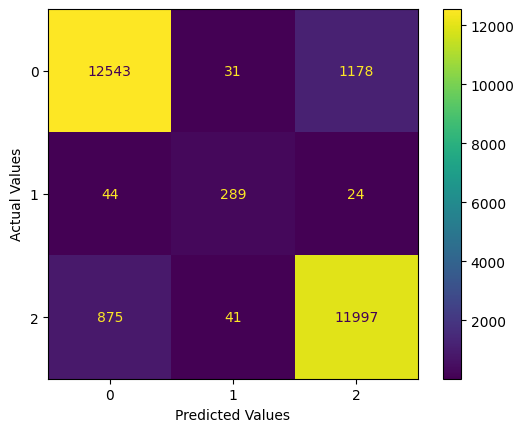

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     13752
           1       0.80      0.81      0.81       357
           2       0.91      0.93      0.92     12913

    accuracy                           0.92     27022
   macro avg       0.88      0.88      0.88     27022
weighted avg       0.92      0.92      0.92     27022



In [ ]:
rf(data_train_df, data_test_df, data_val_df, None, None)

Training score: 0.9441379028467496, Testing score: 0.9128117829916365


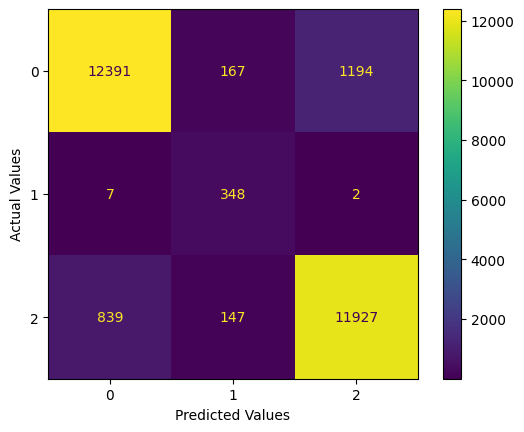

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     13752
           1       0.53      0.97      0.68       357
           2       0.91      0.92      0.92     12913

    accuracy                           0.91     27022
   macro avg       0.79      0.93      0.84     27022
weighted avg       0.92      0.91      0.91     27022



In [ ]:
rf(data_smauto_train_df, data_test_df, data_val_df, None, None)

Training score: 0.9435635899056037, Testing score: 0.9127377692250759


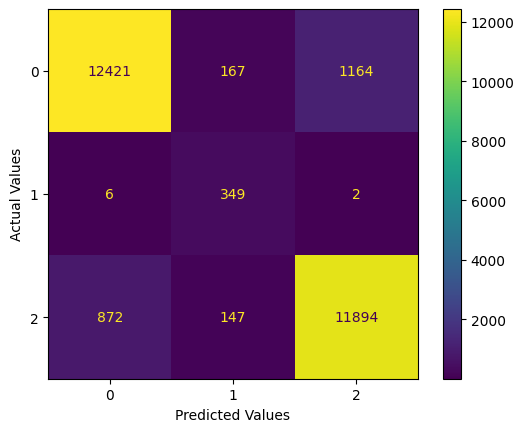

              precision    recall  f1-score   support

           0       0.93      0.90      0.92     13752
           1       0.53      0.98      0.68       357
           2       0.91      0.92      0.92     12913

    accuracy                           0.91     27022
   macro avg       0.79      0.93      0.84     27022
weighted avg       0.92      0.91      0.91     27022



In [ ]:
rf(data_smin_train_df, data_test_df, data_val_df, None, None)

Autoencoder to extract features?

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have a DataFrame 'data_df' with features (X) and labels (y)
# Replace 'your_dataframe.csv' with your actual DataFrame or CSV file.

# Build an Autoencoder
input_dim = X_train.shape[1]  # Number of features
encoding_dim = 2  # Number of neurons in the encoding layer

# Encoder
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder_layer = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
encoder = tf.keras.models.Model(inputs=input_layer, outputs=encoder_layer)

# Decoder
decoder_layer = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoder_layer)
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Train the Autoencoder
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Extract features using the trained encoder
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Use the encoded features with a Random Forest model
rf_classifier = RandomForestClassifier(random_state=47)
rf_classifier.fit(X_train_encoded, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_encoded)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")


Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\carth\AppData\Local\Temp\ipykernel_26472\3113653523.py", line 28, in <module>

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1127, in train_step

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\losses.py", line 143, in __call__

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\losses.py", line 270, in call

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "C:\Users\carth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py", line 5777, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,8] and labels shape [256]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_1445]

In [ ]:
sdfsdf

NameError: name 'sdfsdf' is not defined

https://www.datacamp.com/tutorial/random-forests-classifier-python